# Entso-E example notebook
This notebook demonstrates the use of the entsoe pandas client and explore the data.

In [1]:
from entsoe import EntsoePandasClient  #MIT License
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import json

In order to use the API, you need credentials for the Entso-E Transparency Platform:
To request the access to the Restful API, please register on the Transparency Platform and send an email to transparency@entsoe.eu with “Restful API access” in the subject line. Indicate the email address you entered during registration in the email body. The ENTSO-E Helpdesk will make their best efforts to respond to your request within 3 working days.
https://transparency.entsoe.eu/content/static_content/Static%20content/web%20api/Guide.html


In [2]:
# with open('key.json') as json_file:
#     data = json.load(json_file)
#     key = data['key']

In [3]:
with open('entso_api_key.txt') as file:
    key = file.readline()

## Getting data

In [77]:
zones = {1: '10YNO-1--------2', 
         2: '10YNO-2--------T',
         3: '10YNO-3--------J',
         4: '10YNO-4--------9',
         5: '10Y1001A1001A48H'}

lookup_bzones = True   # True if the country code is a bidding zone

#client = EntsoePandasClient(api_key=key)
client = EntsoePandasClient(api_key=key)
start_date = '20160101'
start = pd.Timestamp(start_date, tz='UTC')
print(start)
end_date = '20211125'
end = pd.Timestamp(end_date, tz='UTC')

2016-01-01 00:00:00+00:00


In [5]:
# # methods that return Pandas Series
# client.query_day_ahead_prices(country_code, start=start,end=end)
# client.query_net_position_dayahead(country_code, start=start, end=end)
# client.query_crossborder_flows(country_code_from, country_code_to, start, end)
# client.query_scheduled_exchanges(country_code_from, country_code_to, start, end, dayahead=False)
# client.query_net_transfer_capacity_dayahead(country_code_from, country_code_to, start, end)
# client.query_net_transfer_capacity_weekahead(country_code_from, country_code_to, start, end)
# client.query_net_transfer_capacity_monthahead(country_code_from, country_code_to, start, end)
# client.query_net_transfer_capacity_yearahead(country_code_from, country_code_to, start, end)
# client.query_intraday_offered_capacity(country_code_from, country_code_to, start, end,implicit=True)

# # methods that return Pandas DataFrames
# client.query_load(country_code, start=start,end=end)
# client.query_load_forecast(country_code, start=start,end=end)
# client.query_load_and_forecast(country_code, start=start, end=end)
# client.query_generation_forecast(country_code, start=start,end=end)
# client.query_wind_and_solar_forecast(country_code, start=start,end=end, psr_type=None)
# client.query_generation(country_code, start=start,end=end, psr_type=None)
# client.query_generation_per_plant(country_code, start=start,end=end, psr_type=None)
# client.query_installed_generation_capacity(country_code, start=start,end=end, psr_type=None)
# client.query_installed_generation_capacity_per_unit(country_code, start=start,end=end, psr_type=None)
# client.query_imbalance_prices(country_code, start=start,end=end, psr_type=None)
# client.query_contracted_reserve_prices(country_code, start, end, type_marketagreement_type, psr_type=None)
# client.query_contracted_reserve_amount(country_code, start, end, type_marketagreement_type, psr_type=None)
# client.query_unavailability_of_generation_units(country_code, start=start,end=end, docstatus=None, periodstartupdate=None, periodendupdate=None)
# client.query_unavailability_of_production_units(country_code, start, end, docstatus=None, periodstartupdate=None, periodendupdate=None)
# client.query_unavailability_transmission(country_code_from, country_code_to, start, end, docstatus=None, periodstartupdate=None, periodendupdate=None)
# client.query_withdrawn_unavailability_of_generation_units(country_code, start, end)
# client.query_import(country_code, start, end)
# client.query_generation_import(country_code, start, end)
# client.query_procured_balancing_capacity(country_code, start, end, process_type, type_marketagreement_type=None)

In [78]:
def rename_columns(df, name):
    columns = {column: name + "".join(column.split()) for column in df.columns}
    df.rename(columns=columns, inplace=True)
    return df

def add_region_prefix(df, zone):
   return df.add_prefix(f"NO{zone}")


In [79]:
## Make main dataset
dataset_main = pd.DataFrame()
for i, idx in tqdm(enumerate(sorted(zones))):
    # Fething data
    day_ahead_prices_ = client.query_day_ahead_prices(zones[idx], start=start, end=end)
    day_ahead_prices = pd.DataFrame(day_ahead_prices_, columns=[f'NO{i+1}_day_ahead_prices'])
    
    load_actual = client.query_load(zones[idx], start=start, end=end).add_prefix(f"NO{i+1}_")

    load_forecast = client.query_load_forecast(zones[idx], start=start, end=end).add_prefix(f"NO{i+1}_")

    generation_volumes_actual = client.query_generation(zones[idx], start=start, end=end, psr_type=None).add_prefix(f"NO{i+1}_")#.sum(axis=1)
    generation_volumes_actual[f"NO{i+1}_generation_actual_sum"] = generation_volumes_actual.sum(axis=1)
    generation_volumes_actual_df= generation_volumes_actual.sum(axis=1).to_frame()
    generation_volumes_actual_df.columns = [f"NO{i+1}_generation_actual"]
    
    
    
    # generation_volumes_actual = pd.DataFrame(generation_volumes_actual_, columns=[f'NO{i+1}_generation_actual'])
    # display(client.query_generation(zones[idx], start=start, end=end, psr_type=None).add_prefix(f"NO{i+1}_"))

    generation_volumes_forecast_ = client.query_generation_forecast(zones[idx], start=start, end=end)#.add_prefix(f"NO{i+1}_").sum(axis=1)
    generation_volumes_forecast = generation_volumes_forecast_.to_frame()
    generation_volumes_forecast.columns = [f"NO{i+1}_generation_forecast"]

    dataset_main = pd.concat([dataset_main, day_ahead_prices, load_actual, load_forecast, generation_volumes_actual_df, generation_volumes_forecast],axis=1)

dato_id = dataset_main.index
dataset_main["dato_id"] = dato_id
display(dataset_main)

dataset_main.to_csv(f'entsoe_dataset_main.csv')

5it [25:28, 305.62s/it]


,NO1_day_ahead_prices,NO1_Actual Load,NO1_Forecasted Load,NO1_generation_actual,NO1_generation_forecast,NO2_day_ahead_prices,NO2_Actual Load,NO2_Forecasted Load,NO2_generation_actual,NO2_generation_forecast,...,NO4_Actual Load,NO4_Forecasted Load,NO4_generation_actual,NO4_generation_forecast,NO5_day_ahead_prices,NO5_Actual Load,NO5_Forecasted Load,NO5_generation_actual,NO5_generation_forecast,dato_id
2016-01-01 01:00:00+01:00,16.04,4482.0,4460.0,3272.0,1649.0,16.04,4010.0,4090.0,15388.0,7801.0,...,2047.0,2071.0,4628.0,2310.0,16.04,2188.0,2135.0,6506.0,3256.0,2016-01-01 01:00:00+01:00
2016-01-01 02:00:00+01:00,15.74,4421.0,4401.0,3264.0,1640.0,15.74,3930.0,4001.0,14876.0,7423.0,...,2070.0,2082.0,4434.0,2227.0,15.74,2155.0,2115.0,6284.0,3160.0,2016-01-01 02:00:00+01:00
2016-01-01 03:00:00+01:00,15.57,4335.0,4323.0,3250.0,1637.0,15.57,3839.0,3920.0,14242.0,7169.0,...,2032.0,2047.0,4294.0,2166.0,15.57,2139.0,2085.0,6110.0,3086.0,2016-01-01 03:00:00+01:00
2016-01-01 04:00:00+01:00,15.47,4304.0,4279.0,3266.0,1642.0,15.47,3833.0,3925.0,14082.0,7049.0,...,2041.0,2055.0,4286.0,2156.0,15.47,2141.0,2090.0,6042.0,3041.0,2016-01-01 04:00:00+01:00
2016-01-01 05:00:00+01:00,15.75,4336.0,4320.0,3272.0,1645.0,15.75,3944.0,4030.0,14492.0,7407.0,...,2069.0,2088.0,4490.0,2258.0,15.75,2168.0,2112.0,6234.0,3136.0,2016-01-01 05:00:00+01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-24 21:00:00+01:00,101.83,4730.0,4705.0,4580.0,2348.0,101.83,4637.0,3823.0,14496.0,7629.0,...,2667.0,2682.0,6966.0,3474.0,101.83,2165.0,2306.0,7312.0,3661.0,2021-11-24 21:00:00+01:00
2021-11-24 22:00:00+01:00,100.66,4463.0,4511.0,4494.0,2235.0,100.66,4520.0,3848.0,13722.0,7113.0,...,2628.0,2652.0,6976.0,3480.0,100.66,2142.0,2245.0,6982.0,3537.0,2021-11-24 22:00:00+01:00
2021-11-24 23:00:00+01:00,96.40,4240.0,4205.0,4392.0,2241.0,96.40,4308.0,3749.0,12368.0,6485.0,...,2558.0,2570.0,6866.0,3424.0,96.40,2085.0,2160.0,6622.0,3410.0,2021-11-24 23:00:00+01:00
2021-11-25 00:00:00+01:00,99.35,3918.0,4039.0,4302.0,2152.0,99.35,4401.0,3621.0,12790.0,6553.0,...,2477.0,2486.0,6640.0,3287.0,99.35,2007.0,2116.0,6196.0,3197.0,2021-11-25 00:00:00+01:00


In [75]:
dato_id = dataset_main.index
dataset_main["dato_id"] = dato_id
display(dataset_main)

dataset_main.to_csv(f'entsoe_dataset_main.csv')

,NO1_day_ahead_prices,NO1_Actual Load,NO1_Forecasted Load,NO1_generation_actual,NO1_generation_forecast,NO2_day_ahead_prices,NO2_Actual Load,NO2_Forecasted Load,NO2_generation_actual,NO2_generation_forecast,...,NO4_Actual Load,NO4_Forecasted Load,NO4_generation_actual,NO4_generation_forecast,NO5_day_ahead_prices,NO5_Actual Load,NO5_Forecasted Load,NO5_generation_actual,NO5_generation_forecast,dato_id
2020-11-20 01:00:00+01:00,1.13,4273.0,4436.0,5776.0,2886.0,1.13,4601.0,4453.0,12368.0,5968.0,...,2083.0,2370.0,3610.0,1630.0,1.13,2039.0,1930.0,6206.0,2903.0,2020-11-20 01:00:00+01:00
2020-11-20 02:00:00+01:00,1.29,4210.0,4296.0,5704.0,2879.0,1.29,4637.0,4378.0,12118.0,5945.0,...,2118.0,2375.0,3562.0,1604.0,1.29,2020.0,1904.0,6370.0,3003.0,2020-11-20 02:00:00+01:00
2020-11-20 03:00:00+01:00,1.40,4202.0,4185.0,5660.0,2876.0,1.40,4573.0,4317.0,11842.0,5909.0,...,2071.0,2355.0,3636.0,1599.0,1.40,2048.0,1940.0,6500.0,3092.0,2020-11-20 03:00:00+01:00
2020-11-20 04:00:00+01:00,1.42,4284.0,4255.0,5636.0,2890.0,1.42,4491.0,4345.0,11942.0,5959.0,...,2061.0,2295.0,3552.0,1581.0,1.42,2040.0,1991.0,6802.0,3198.0,2020-11-20 04:00:00+01:00
2020-11-20 05:00:00+01:00,1.46,4589.0,4429.0,5458.0,2933.0,1.46,4553.0,4199.0,12526.0,6214.0,...,2110.0,2370.0,3640.0,1638.0,1.46,2081.0,2061.0,7374.0,3530.0,2020-11-20 05:00:00+01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24 21:00:00+01:00,2.02,4765.0,4760.0,5054.0,2560.0,2.02,4649.0,4135.0,17982.0,9043.0,...,2314.0,2529.0,5882.0,2818.0,2.02,2050.0,2125.0,6698.0,3395.0,2020-11-24 21:00:00+01:00
2020-11-24 22:00:00+01:00,1.73,4476.0,4495.0,5080.0,2574.0,1.73,4391.0,3984.0,17682.0,8909.0,...,2171.0,2476.0,4484.0,2155.0,1.73,2010.0,2040.0,6122.0,3080.0,2020-11-24 22:00:00+01:00
2020-11-24 23:00:00+01:00,1.59,4200.0,4170.0,5044.0,2565.0,1.59,4267.0,3696.0,16890.0,8499.0,...,2095.0,2386.0,4450.0,2106.0,1.59,1949.0,1918.0,6012.0,3014.0,2020-11-24 23:00:00+01:00
2020-11-25 00:00:00+01:00,1.61,3922.0,3916.0,5064.0,2571.0,1.61,4176.0,3716.0,15568.0,7873.0,...,2020.0,2231.0,4142.0,1933.0,1.61,1925.0,1867.0,6022.0,3054.0,2020-11-25 00:00:00+01:00


Text(0.5, 0, 'Date')

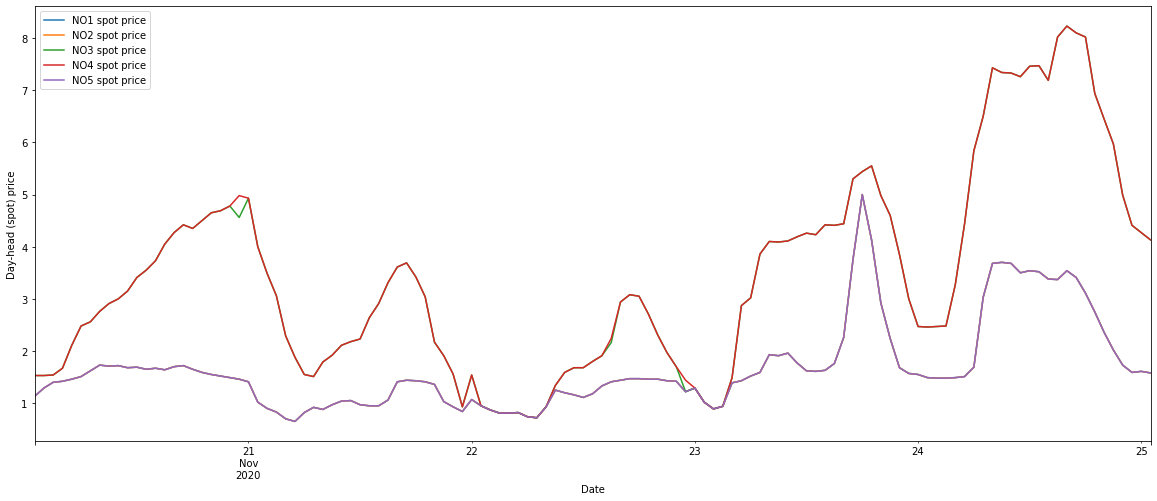

In [76]:
ax = dataset_main.plot("dato_id", "NO1_day_ahead_prices", figsize=(20,8), label="NO1 spot price")
dataset_main.plot("dato_id", "NO2_day_ahead_prices", ax=ax, figsize=(20,8), label="NO2 spot price")
dataset_main.plot("dato_id", "NO3_day_ahead_prices", ax=ax, figsize=(20,8), label="NO3 spot price")
dataset_main.plot("dato_id", "NO4_day_ahead_prices", ax=ax, figsize=(20,8), label="NO4 spot price")
dataset_main.plot("dato_id", "NO5_day_ahead_prices", ax=ax, figsize=(20,8), label="NO5 spot price")
plt.ylabel("Day-head (spot) price")
plt.xlabel("Date")